# CARDEC Trial (Global) - Machine Learning Prediction Models

In [1]:
# Install required packages
!pip install scikit-learn numpy pandas scipy \
joblib threadpoolctl cython \
imbalanced-learn xgboost catboost \
keras tensorflow focal-loss shap \
matplotlib seaborn

In [2]:
# Import necessary libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, StratifiedKFold, GridSearchCV
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, roc_curve, confusion_matrix
from sklearn.pipeline import Pipeline
import xgboost as xgb
import catboost as cb
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, BatchNormalization
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.regularizers import l2
from keras import backend as K
import warnings
warnings.filterwarnings('ignore')

# Set random seed for reproducibility
np.random.seed(42)
tf.random.set_seed(42)

# Set style for plots
plt.style.use('default')
sns.set_palette("husl")

## Data Loading and Preprocessing
### Patient-level train-test split (80:20) - CARDEC methodology

In [3]:
# Load the data from Excel file
data = pd.read_excel('2024_corrected_global_CARDEC_3_ML_Vitor.xlsx')

print(f"Dataset shape: {data.shape}")
print(f"Target distribution: {data['Failure'].value_counts()}")
print(f"Failure rate: {data['Failure'].mean():.1%}")

Dataset shape: (637, 17)
Target distribution: Failure
0    326
1    311
Name: count, dtype: int64
Failure rate: 48.8%


In [4]:
# Patient-level train-test split (80:20 as per CARDEC methodology)
# Ensures no patient data leakage between train and test sets
unique_n_part = data['IDpac'].unique()
train_n_part, test_n_part = train_test_split(unique_n_part, test_size=0.2, random_state=42)

train_data = data[data['IDpac'].isin(train_n_part)]
test_data = data[data['IDpac'].isin(test_n_part)]

# Separate features and target variable
X_train = train_data.drop(['Failure', 'IDrest', 'IDpac'], axis=1)
y_train = train_data['Failure']
X_test = test_data.drop(['Failure', 'IDrest', 'IDpac'], axis=1)
y_test = test_data['Failure']

print(f"Training set: {len(X_train)} samples, {y_train.sum()} failures ({y_train.mean():.1%})")
print(f"Test set: {len(X_test)} samples, {y_test.sum()} failures ({y_test.mean():.1%})")
print(f"Split ratio: {len(X_train)/(len(X_train)+len(X_test)):.1%}:{len(X_test)/(len(X_train)+len(X_test)):.1%}")

Training set: 507 samples, 251 failures (49.5%)
Test set: 130 samples, 60 failures (46.2%)
Split ratio: 79.6%:20.4%


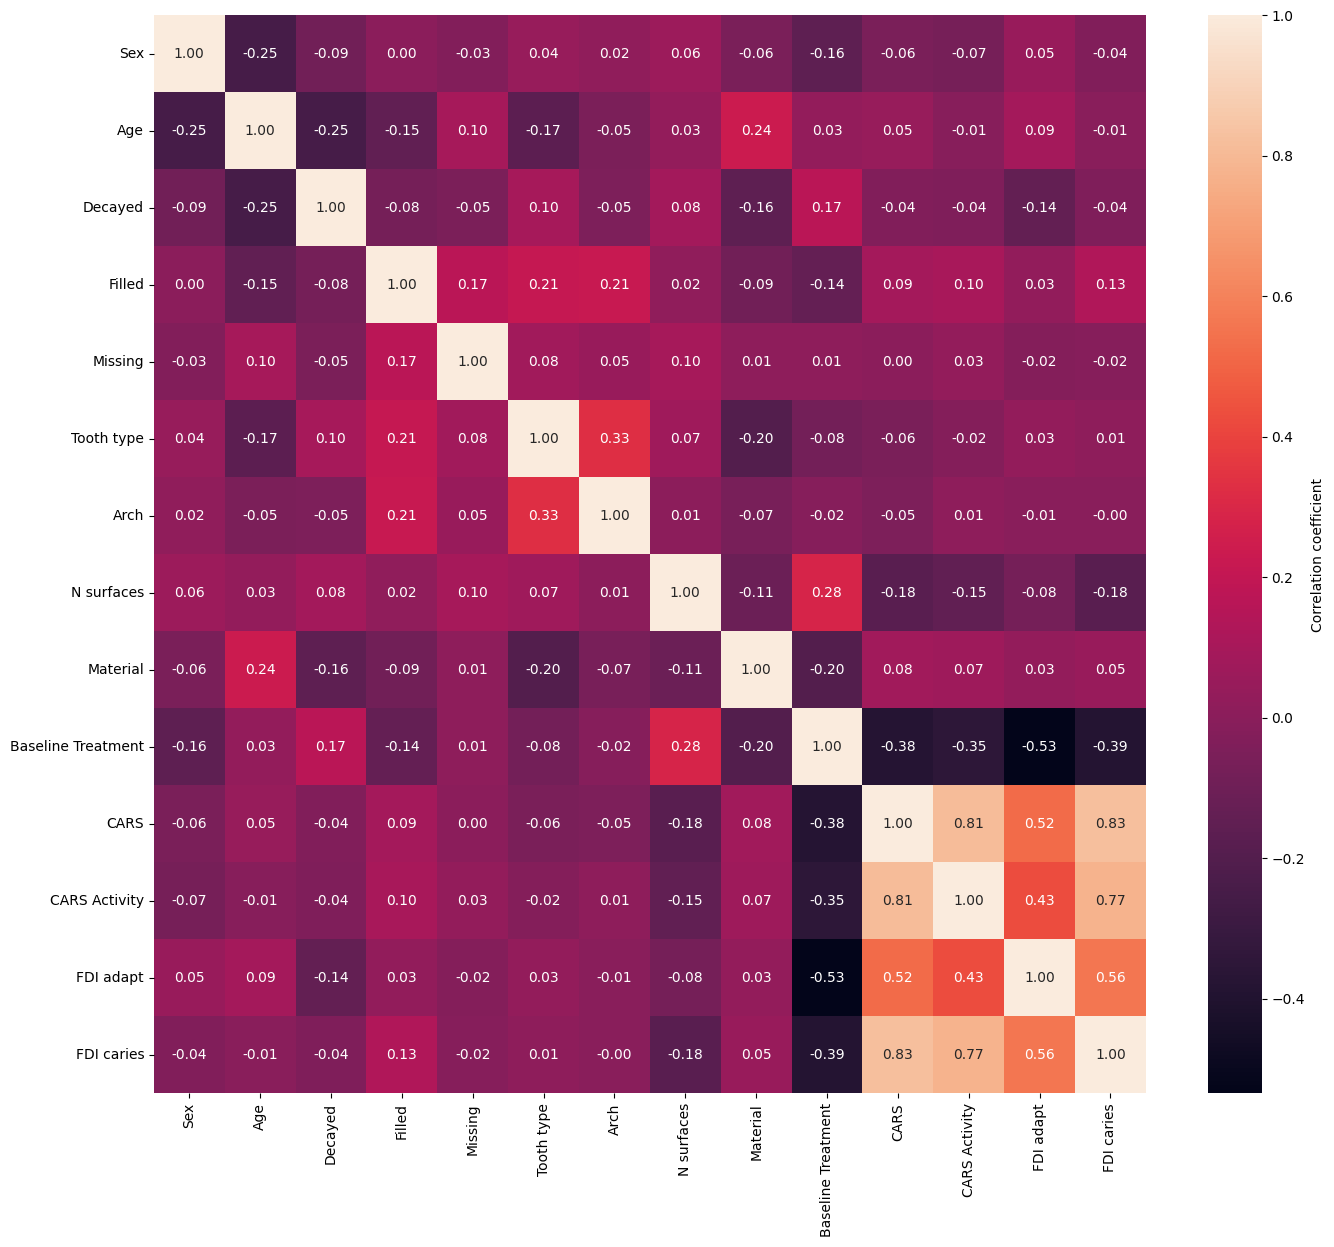

In [5]:
import seaborn as sns
import matplotlib.pyplot as plt

# Calculate the correlation matrix of the training data.
# The correlation matrix quantifies the linear relationships between the variables in `X_train`.
corr_matrix = X_train.corr()

# Initialize a matplotlib figure with a specified size (width=16 inches, height=14 inches) for displaying the heatmap.
# This size is chosen to make the heatmap large enough to be easily readable.
plt.figure(figsize=(16, 14))

# Draw the heatmap using seaborn to visualize the correlation matrix.
sns.heatmap(corr_matrix, annot=True, annot_kws={"size": 10}, fmt=".2f", cbar_kws={'label': 'Correlation coefficient'})

# Display the plot on the screen. This command is necessary to show the figure when using matplotlib in scripts.
plt.show()

In [6]:
import pandas as pd

# Define lists for each type of variable in the dataset: numeric, binary, and ordinal variables.
numeric_vars = ['Age', 'Decayed', 'Filled', 'Missing']
binary_vars = ['Sex', 'Tooth type', 'Arch', 'Failure', 'CARS Activity']
categorical_vars = ['N surfaces', 'Material', 'Baseline Treatment', 'CARS', 'FDI adapt', 'FDI caries']

def descriptive_statistics(train_data, test_data):
    # Print a heading for the descriptive statistics of numeric variables.
    print("Descriptive Statistics for Numeric Variables:")
    # Display descriptive statistics (like count, mean, std, min, max, etc.) for numeric variables in the training set.
    print("\nTraining Set:")
    print(train_data[numeric_vars].describe())
    # Repeat the process for the test set.
    print("\nTest Set:")
    print(test_data[numeric_vars].describe())

    # Initialize an empty dictionary to store statistics for binary and ordinal variables.
    stats = {}
    # Loop through each variable in the binary and ordinal lists to calculate their counts and percentages.
    for var in binary_vars + categorical_vars:
        stats[var] = {
            "Training Set": {
                "Count": train_data[var].value_counts().to_dict(),  # Count occurrences of each value in the training set.
                "Percentage": (train_data[var].value_counts(normalize=True) * 100).to_dict()  # Calculate percentage of each value in the training set.
            },
            "Test Set": {
                "Count": test_data[var].value_counts().to_dict(),  # Count occurrences of each value in the test set.
                "Percentage": (test_data[var].value_counts(normalize=True) * 100).to_dict()  # Calculate percentage of each value in the test set.
            }
        }

    # Loop through the stats dictionary to print the statistics for each categorical variable (binary and categorical).
    for var, data in stats.items():
        print(f"\n{var} Statistics:")  # Print the variable name.
        for dataset, values in data.items():
            print(f"\n{dataset}:")  # Print which dataset (training or test) the statistics are for.
            for metric, metric_values in values.items():
                print(f"{metric}: {metric_values}")  # Print the count and percentage of values for the variable.

# Call the function with the training and test datasets as arguments to display the descriptive statistics.
descriptive_statistics(train_data, test_data)


Descriptive Statistics for Numeric Variables:

Training Set:
              Age     Decayed      Filled     Missing
count  507.000000  507.000000  507.000000  507.000000
mean     6.887738    1.631164    5.903353    0.568047
std      1.558667    2.074705    2.526642    0.941366
min      3.750000    0.000000    1.000000    0.000000
25%      5.750000    0.000000    4.000000    0.000000
50%      6.750000    1.000000    6.000000    0.000000
75%      8.000000    3.000000    8.000000    1.000000
max     10.166667   14.000000   12.000000    4.000000

Test Set:
              Age     Decayed      Filled     Missing
count  130.000000  130.000000  130.000000  130.000000
mean     6.605769    1.830769    6.138462    0.553846
std      1.547962    1.703341    2.599206    0.915513
min      3.583333    0.000000    1.000000    0.000000
25%      5.416667    1.000000    4.000000    0.000000
50%      6.333333    1.500000    6.000000    0.000000
75%      7.833333    3.000000    8.000000    1.000000
max      9

In [7]:
# Data preprocessing
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler
import pandas as pd

# Display basic info about the dataset
print("Dataset columns:", X_train.columns.tolist())
print("\nData types:")
print(X_train.dtypes)
print("\nMissing values:")
print(X_train.isnull().sum())

# Handle missing values if any
if X_train.isnull().sum().sum() > 0:
    # Impute missing values
    numeric_columns = X_train.select_dtypes(include=[np.number]).columns
    categorical_columns = X_train.select_dtypes(exclude=[np.number]).columns

    if len(numeric_columns) > 0:
        imputer_num = SimpleImputer(strategy='median')
        X_train[numeric_columns] = imputer_num.fit_transform(X_train[numeric_columns])
        X_test[numeric_columns] = imputer_num.transform(X_test[numeric_columns])

    if len(categorical_columns) > 0:
        imputer_cat = SimpleImputer(strategy='most_frequent')
        X_train[categorical_columns] = imputer_cat.fit_transform(X_train[categorical_columns])
        X_test[categorical_columns] = imputer_cat.transform(X_test[categorical_columns])

# Scale numerical features if needed
numeric_columns = X_train.select_dtypes(include=[np.number]).columns
if len(numeric_columns) > 0:
    scaler = StandardScaler()
    X_train[numeric_columns] = scaler.fit_transform(X_train[numeric_columns])
    X_test[numeric_columns] = scaler.transform(X_test[numeric_columns])

# Final data check
X_train = X_train.fillna(0)
X_test = X_test.fillna(0)

print(f"\nFinal feature shape: {X_train.shape}")
print(f"NaN check - Train: {X_train.isnull().sum().sum()}, Test: {X_test.isnull().sum().sum()}")
print(f"Feature names: {list(X_train.columns)}")

Dataset columns: ['Sex', 'Age', 'Decayed', 'Filled', 'Missing', 'Tooth type', 'Arch', 'N surfaces', 'Material', 'Baseline Treatment', 'CARS', 'CARS Activity', 'FDI adapt', 'FDI caries']

Data types:
Sex                     int64
Age                   float64
Decayed                 int64
Filled                  int64
Missing                 int64
Tooth type              int64
Arch                    int64
N surfaces              int64
Material                int64
Baseline Treatment      int64
CARS                    int64
CARS Activity           int64
FDI adapt               int64
FDI caries              int64
dtype: object

Missing values:
Sex                   0
Age                   0
Decayed               0
Filled                0
Missing               0
Tooth type            0
Arch                  0
N surfaces            0
Material              0
Baseline Treatment    0
CARS                  0
CARS Activity         0
FDI adapt             0
FDI caries            0
dtype: int64



## Utility Functions
### Consistent threshold optimization and model evaluation

In [8]:
# Optimal threshold selection based on F1-score maximization
import numpy as np
from sklearn.metrics import (
    f1_score, accuracy_score, precision_score, recall_score,
    roc_auc_score
)
from sklearn.model_selection import StratifiedKFold, GridSearchCV

def find_optimal_threshold(y_true, y_proba):
    """Find optimal threshold based on F1-score maximization."""
    thresholds = np.arange(0.1, 1.01, 0.05)
    best_f1 = 0
    best_threshold = 0.5

    for threshold in thresholds:
        y_pred = (y_proba >= threshold).astype(int)
        f1 = f1_score(y_true, y_pred, zero_division=0)
        if f1 > best_f1:
            best_f1 = f1
            best_threshold = threshold

    return best_threshold


def evaluate_model_with_seeds(pipeline, param_grid, X_train, y_train, X_test, y_test, model_name, n_seeds=10):
    """Evaluate model with multiple seeds for robustness."""
    seeds = [40, 41, 42, 43, 44, 45, 46, 47, 48, 49]
    all_results = []
    all_predictions = []  # Store all predictions for averaging

    print(f"\nTraining {model_name} with {n_seeds} seeds...")

    for i, seed in enumerate(seeds[:n_seeds]):
        print(f"  Seed {i+1}/{n_seeds}: {seed}")

        # Set random states
        np.random.seed(seed)

        # Update pipeline random states
        if hasattr(pipeline.named_steps['classifier'], 'random_state'):
            pipeline.set_params(**{f'classifier__random_state': seed})

        # Cross-validation setup
        cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=seed)

        # Grid search with cross-validation
        grid_search = GridSearchCV(
            pipeline, param_grid, cv=cv, scoring='f1', n_jobs=-1, verbose=0
        )

        # Fit model
        grid_search.fit(X_train, y_train)

        # Get predictions
        y_pred_proba = grid_search.predict_proba(X_test)[:, 1]
        all_predictions.append(y_pred_proba)  # Store for averaging

        # Find optimal threshold
        optimal_threshold = find_optimal_threshold(y_test, y_pred_proba)
        y_pred = (y_pred_proba >= optimal_threshold).astype(int)

        # Calculate metrics
        seed_results = {
            'seed': seed,
            'accuracy': accuracy_score(y_test, y_pred),
            'precision': precision_score(y_test, y_pred, zero_division=0),
            'recall': recall_score(y_test, y_pred, zero_division=0),
            'f1': f1_score(y_test, y_pred, zero_division=0),
            'auc': roc_auc_score(y_test, y_pred_proba),
            'threshold': optimal_threshold,
            'cv_score': grid_search.best_score_,
            'best_params': grid_search.best_params_,
            'model': grid_search.best_estimator_,
            'y_pred_proba': y_pred_proba
        }

        all_results.append(seed_results)

    # Calculate averaged predictions across all seeds
    avg_predictions = np.mean(all_predictions, axis=0)

    # Calculate statistics across seeds
    metrics = ['accuracy', 'precision', 'recall', 'f1', 'auc', 'threshold', 'cv_score']
    final_results = {}

    for metric in metrics:
        values = [r[metric] for r in all_results]
        final_results[f'{metric}_mean'] = np.mean(values)
        final_results[f'{metric}_std'] = np.std(values)

    # Best individual result (for SHAP analysis)
    best_result = max(all_results, key=lambda x: x['auc'])
    final_results['best_model'] = best_result['model']
    final_results['best_params'] = best_result['best_params']

    # Use averaged predictions for consistent reporting
    final_results['avg_predictions'] = avg_predictions
    final_results['all_results'] = all_results

    return final_results, all_results


def display_model_summary(results, model_name):
    """Display comprehensive model summary with consistent metrics."""
    print(f"\n{'='*60}")
    print(f"{model_name.upper()} RESULTS SUMMARY (10 Seeds)")
    print(f"{'='*60}")

    # Display mean ± std for all metrics
    if 'cv_score_mean' in results:
        print(f"Mean CV F1 Score: {results['cv_score_mean']:.4f} ± {results['cv_score_std']:.4f}")
        print(f"Mean Test AUC: {results['auc_mean']:.4f} ± {results['auc_std']:.4f}")
        print(f"Mean Test F1: {results['f1_mean']:.4f} ± {results['f1_std']:.4f}")
        print(f"Mean Test Accuracy: {results['accuracy_mean']:.4f} ± {results['accuracy_std']:.4f}")
        print(f"Mean Test Precision: {results['precision_mean']:.4f} ± {results['precision_std']:.4f}")
        print(f"Mean Test Recall: {results['recall_mean']:.4f} ± {results['recall_std']:.4f}")
        print(f"Mean Optimal Threshold: {results['threshold_mean']:.4f} ± {results['threshold_std']:.4f}")

    if 'best_params' in results:
        print(f"Best Parameters: {results['best_params']}")

    # Show threshold evaluation using AVERAGED predictions
    print(f"\nThreshold evaluation using averaged predictions across 10 seeds:")
    avg_predictions = results['avg_predictions']

    # Calculate AUC with averaged predictions
    avg_auc = roc_auc_score(y_test, avg_predictions)
    print(f"AUC with averaged predictions: {avg_auc:.4f}")

    # Find optimal threshold with averaged predictions
    optimal_threshold = find_optimal_threshold(y_test, avg_predictions)
    y_pred_optimal = (avg_predictions >= optimal_threshold).astype(int)

    # Calculate metrics with optimal threshold
    optimal_accuracy = accuracy_score(y_test, y_pred_optimal)
    optimal_precision = precision_score(y_test, y_pred_optimal, zero_division=0)
    optimal_recall = recall_score(y_test, y_pred_optimal, zero_division=0)
    optimal_f1 = f1_score(y_test, y_pred_optimal, zero_division=0)

    print(f"Optimal threshold: {optimal_threshold:.3f}")
    print(f"Performance at optimal threshold:")
    print(f"  Accuracy: {optimal_accuracy:.4f}")
    print(f"  Precision: {optimal_precision:.4f}")
    print(f"  Recall: {optimal_recall:.4f}")
    print(f"  F1-Score: {optimal_f1:.4f}")

    return avg_predictions

## Decision Tree Model
### Parameter grid optimization with CARDEC hyperparameters

In [9]:
# Decision Tree with CARDEC-specific parameter grid
print("Training Decision Tree...")

# Create pipeline
dt_pipeline = Pipeline([
    ('classifier', DecisionTreeClassifier())
])

# CARDEC-specific parameter grid
dt_param_grid = {
    'classifier__max_depth': [5, 10, 15, 20, None],
    'classifier__criterion': ['gini', 'entropy'],
    'classifier__min_samples_split': [2, 5, 10],
    'classifier__min_samples_leaf': [1, 2, 4]
}

print(f"Parameter combinations: {np.prod([len(v) for v in dt_param_grid.values()])}")

# Evaluate with multiple seeds
dt_results, dt_detailed = evaluate_model_with_seeds(
    dt_pipeline, dt_param_grid, X_train, y_train, X_test, y_test, 'Decision Tree', n_seeds=10
)

# Display results
dt_avg_predictions = display_model_summary(dt_results, 'Decision Tree')

Training Decision Tree...
Parameter combinations: 90

Training Decision Tree with 10 seeds...
  Seed 1/10: 40
  Seed 2/10: 41
  Seed 3/10: 42
  Seed 4/10: 43
  Seed 5/10: 44
  Seed 6/10: 45
  Seed 7/10: 46
  Seed 8/10: 47
  Seed 9/10: 48
  Seed 10/10: 49

DECISION TREE RESULTS SUMMARY (10 Seeds)
Mean CV F1 Score: 0.6524 ± 0.0165
Mean Test AUC: 0.6701 ± 0.0094
Mean Test F1: 0.6623 ± 0.0063
Mean Test Accuracy: 0.6085 ± 0.0276
Mean Test Precision: 0.5526 ± 0.0232
Mean Test Recall: 0.8317 ± 0.0540
Mean Optimal Threshold: 0.3550 ± 0.0350
Best Parameters: {'classifier__criterion': 'gini', 'classifier__max_depth': 5, 'classifier__min_samples_leaf': 2, 'classifier__min_samples_split': 2}

Threshold evaluation using averaged predictions across 10 seeds:
AUC with averaged predictions: 0.7064
Optimal threshold: 0.250
Performance at optimal threshold:
  Accuracy: 0.5308
  Precision: 0.4957
  Recall: 0.9667
  F1-Score: 0.6554


## Random Forest Model
### Parameter grid optimization with CARDEC hyperparameters

In [10]:
# Random Forest with CARDEC-specific parameter grid
print("Training Random Forest...")

# Create pipeline
rf_pipeline = Pipeline([
    ('classifier', RandomForestClassifier())
])

# CARDEC-specific parameter grid
rf_param_grid = {
    'classifier__n_estimators': [100, 200, 300],
    'classifier__max_depth': [5, 10, 15],
    'classifier__min_samples_split': [2, 5, 10],
    'classifier__min_samples_leaf': [1, 2, 4]
}

print(f"Parameter combinations: {np.prod([len(v) for v in rf_param_grid.values()])}")

# Evaluate with multiple seeds
rf_results, rf_detailed = evaluate_model_with_seeds(
    rf_pipeline, rf_param_grid, X_train, y_train, X_test, y_test, 'Random Forest', n_seeds=10
)

# Display results
rf_avg_predictions = display_model_summary(rf_results, 'Random Forest')

Training Random Forest...
Parameter combinations: 81

Training Random Forest with 10 seeds...
  Seed 1/10: 40
  Seed 2/10: 41
  Seed 3/10: 42
  Seed 4/10: 43
  Seed 5/10: 44
  Seed 6/10: 45
  Seed 7/10: 46
  Seed 8/10: 47
  Seed 9/10: 48
  Seed 10/10: 49

RANDOM FOREST RESULTS SUMMARY (10 Seeds)
Mean CV F1 Score: 0.6703 ± 0.0144
Mean Test AUC: 0.7551 ± 0.0056
Mean Test F1: 0.7152 ± 0.0115
Mean Test Accuracy: 0.6846 ± 0.0349
Mean Test Precision: 0.6186 ± 0.0391
Mean Test Recall: 0.8550 ± 0.0533
Mean Optimal Threshold: 0.4700 ± 0.0400
Best Parameters: {'classifier__max_depth': 5, 'classifier__min_samples_leaf': 1, 'classifier__min_samples_split': 2, 'classifier__n_estimators': 100}

Threshold evaluation using averaged predictions across 10 seeds:
AUC with averaged predictions: 0.7590
Optimal threshold: 0.500
Performance at optimal threshold:
  Accuracy: 0.7154
  Precision: 0.6575
  Recall: 0.8000
  F1-Score: 0.7218


## XGBoost Model
### Parameter grid optimization with CARDEC hyperparameters

In [11]:
# XGBoost with CARDEC-specific parameter grid
print("Training XGBoost...")

# Create pipeline
xgb_pipeline = Pipeline([
    ('classifier', xgb.XGBClassifier(eval_metric='logloss'))
])

# CARDEC-specific parameter grid
xgb_param_grid = {
    'classifier__n_estimators': [100, 200, 300],
    'classifier__max_depth': [3, 6, 9],
    'classifier__learning_rate': [0.01, 0.1, 0.2],
    'classifier__subsample': [0.8, 0.9, 1.0]
}

print(f"Parameter combinations: {np.prod([len(v) for v in xgb_param_grid.values()])}")

# Evaluate with multiple seeds
xgb_results, xgb_detailed = evaluate_model_with_seeds(
    xgb_pipeline, xgb_param_grid, X_train, y_train, X_test, y_test, 'XGBoost', n_seeds=10
)

# Display results
xgb_avg_predictions = display_model_summary(xgb_results, 'XGBoost')

Training XGBoost...
Parameter combinations: 81

Training XGBoost with 10 seeds...
  Seed 1/10: 40
  Seed 2/10: 41
  Seed 3/10: 42
  Seed 4/10: 43
  Seed 5/10: 44
  Seed 6/10: 45
  Seed 7/10: 46
  Seed 8/10: 47
  Seed 9/10: 48
  Seed 10/10: 49

XGBOOST RESULTS SUMMARY (10 Seeds)
Mean CV F1 Score: 0.6747 ± 0.0103
Mean Test AUC: 0.7374 ± 0.0207
Mean Test F1: 0.7156 ± 0.0066
Mean Test Accuracy: 0.6869 ± 0.0129
Mean Test Precision: 0.6168 ± 0.0152
Mean Test Recall: 0.8533 ± 0.0233
Mean Optimal Threshold: 0.4950 ± 0.0150
Best Parameters: {'classifier__learning_rate': 0.01, 'classifier__max_depth': 3, 'classifier__n_estimators': 300, 'classifier__subsample': 1.0}

Threshold evaluation using averaged predictions across 10 seeds:
AUC with averaged predictions: 0.7440
Optimal threshold: 0.500
Performance at optimal threshold:
  Accuracy: 0.7000
  Precision: 0.6296
  Recall: 0.8500
  F1-Score: 0.7234


## Neural Network Model
### Custom implementation with CARDEC hyperparameters

In [13]:
# Neural Network with CARDEC-specific architecture
print("Training Neural Network...")

def create_nn_model(input_dim, hidden_units=64, dropout_rate=0.3, l2_reg=0.01):
    """Create neural network model with CARDEC specifications."""
    model = Sequential([
        Dense(hidden_units, activation='relu', input_dim=input_dim,
              kernel_regularizer=l2(l2_reg)),
        BatchNormalization(),
        Dropout(dropout_rate),
        Dense(hidden_units//2, activation='relu',
              kernel_regularizer=l2(l2_reg)),
        BatchNormalization(),
        Dropout(dropout_rate),
        Dense(1, activation='sigmoid')
    ])

    model.compile(
        optimizer='adam',
        loss='binary_crossentropy',
        metrics=['accuracy']
    )

    return model

def evaluate_nn_with_seeds(X_train, y_train, X_test, y_test, n_seeds=10):
    """Evaluate Neural Network with multiple seeds."""
    seeds = [40, 41, 42, 43, 44, 45, 46, 47, 48, 49]
    all_results = []
    all_predictions = []

    for i, seed in enumerate(seeds[:n_seeds]):
        print(f"  Seed {i+1}/{n_seeds}: {seed}")

        # Set random seeds
        np.random.seed(seed)
        tf.random.set_seed(seed)

        # Create and train model
        model = create_nn_model(X_train.shape[1])

        # Callbacks
        early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
        reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=5, min_lr=0.001)

        # Train model
        history = model.fit(
            X_train, y_train,
            epochs=100,
            batch_size=32,
            validation_split=0.2,
            callbacks=[early_stopping, reduce_lr],
            verbose=0
        )

        # Get predictions
        y_pred_proba = model.predict(X_test, verbose=0).ravel()
        all_predictions.append(y_pred_proba)

        # Find optimal threshold
        optimal_threshold = find_optimal_threshold(y_test, y_pred_proba)
        y_pred = (y_pred_proba >= optimal_threshold).astype(int)

        # Calculate metrics
        seed_results = {
            'seed': seed,
            'accuracy': accuracy_score(y_test, y_pred),
            'precision': precision_score(y_test, y_pred, zero_division=0),
            'recall': recall_score(y_test, y_pred, zero_division=0),
            'f1': f1_score(y_test, y_pred, zero_division=0),
            'auc': roc_auc_score(y_test, y_pred_proba),
            'threshold': optimal_threshold,
            'model': model,
            'y_pred_proba': y_pred_proba
        }

        all_results.append(seed_results)

    # Calculate averaged predictions
    avg_predictions = np.mean(all_predictions, axis=0)

    # Calculate statistics
    metrics = ['accuracy', 'precision', 'recall', 'f1', 'auc', 'threshold']
    final_results = {}

    for metric in metrics:
        values = [r[metric] for r in all_results]
        final_results[f'{metric}_mean'] = np.mean(values)
        final_results[f'{metric}_std'] = np.std(values)

    # Best individual result
    best_result = max(all_results, key=lambda x: x['auc'])
    final_results['best_model'] = best_result['model']
    final_results['avg_predictions'] = avg_predictions
    final_results['all_results'] = all_results

    return final_results, all_results

# Evaluate Neural Network
nn_results, nn_detailed = evaluate_nn_with_seeds(X_train, y_train, X_test, y_test, n_seeds=10)

# Display results
def display_nn_summary(results, model_name):
    """Display Neural Network summary."""
    print(f"\n{'='*60}")
    print(f"{model_name.upper()} RESULTS SUMMARY (10 Seeds)")
    print(f"{'='*60}")

    print(f"Mean Test AUC: {results['auc_mean']:.4f} ± {results['auc_std']:.4f}")
    print(f"Mean Test F1: {results['f1_mean']:.4f} ± {results['f1_std']:.4f}")
    print(f"Mean Test Accuracy: {results['accuracy_mean']:.4f} ± {results['accuracy_std']:.4f}")
    print(f"Mean Test Precision: {results['precision_mean']:.4f} ± {results['precision_std']:.4f}")
    print(f"Mean Test Recall: {results['recall_mean']:.4f} ± {results['recall_std']:.4f}")
    print(f"Mean Optimal Threshold: {results['threshold_mean']:.4f} ± {results['threshold_std']:.4f}")

    # Show threshold evaluation using AVERAGED predictions
    print(f"\nThreshold evaluation using averaged predictions across 10 seeds:")
    avg_predictions = results['avg_predictions']

    # Calculate AUC with averaged predictions
    avg_auc = roc_auc_score(y_test, avg_predictions)
    print(f"AUC with averaged predictions: {avg_auc:.4f}")

    # Find optimal threshold with averaged predictions
    optimal_threshold = find_optimal_threshold(y_test, avg_predictions)
    y_pred_optimal = (avg_predictions >= optimal_threshold).astype(int)

    # Calculate metrics with optimal threshold
    optimal_accuracy = accuracy_score(y_test, y_pred_optimal)
    optimal_precision = precision_score(y_test, y_pred_optimal, zero_division=0)
    optimal_recall = recall_score(y_test, y_pred_optimal, zero_division=0)
    optimal_f1 = f1_score(y_test, y_pred_optimal, zero_division=0)

    print(f"Optimal threshold: {optimal_threshold:.3f}")
    print(f"Performance at optimal threshold:")
    print(f"  Accuracy: {optimal_accuracy:.4f}")
    print(f"  Precision: {optimal_precision:.4f}")
    print(f"  Recall: {optimal_recall:.4f}")
    print(f"  F1-Score: {optimal_f1:.4f}")

    return avg_predictions

nn_avg_predictions = display_nn_summary(nn_results, 'Neural Network')

Training Neural Network...
  Seed 1/10: 40
  Seed 2/10: 41
  Seed 3/10: 42


  Seed 4/10: 43
  Seed 5/10: 44
  Seed 6/10: 45
  Seed 7/10: 46
  Seed 8/10: 47
  Seed 9/10: 48
  Seed 10/10: 49

NEURAL NETWORK RESULTS SUMMARY (10 Seeds)
Mean Test AUC: 0.7453 ± 0.0256
Mean Test F1: 0.7158 ± 0.0282
Mean Test Accuracy: 0.6731 ± 0.0550
Mean Test Precision: 0.6048 ± 0.0497
Mean Test Recall: 0.8850 ± 0.0497
Mean Optimal Threshold: 0.3400 ± 0.0860

Threshold evaluation using averaged predictions across 10 seeds:
AUC with averaged predictions: 0.7633
Optimal threshold: 0.350
Performance at optimal threshold:
  Accuracy: 0.6692
  Precision: 0.5934
  Recall: 0.9000
  F1-Score: 0.7152


## CatBoost Model
### Parameter grid optimization with CARDEC hyperparameters

In [12]:
# CatBoost with CARDEC-specific parameter grid
print("Training CatBoost...")

# Prepare data for CatBoost
X_train_cb = X_train.copy()
X_test_cb = X_test.copy()

# Convert categorical and boolean columns to numeric
for col in X_train_cb.columns:
    if X_train_cb[col].dtype in ['category', 'bool', 'object']:
        X_train_cb[col] = X_train_cb[col].astype('int')
        X_test_cb[col] = X_test_cb[col].astype('int')

X_train_cb = X_train_cb.fillna(0)
X_test_cb = X_test_cb.fillna(0)

# Create pipeline
cb_pipeline = Pipeline([
    ('classifier', cb.CatBoostClassifier(verbose=False))
])

# CARDEC-specific parameter grid (from original CARDEC CatBoost)
cb_param_grid = {
    'classifier__iterations': [100, 200, 300],
    'classifier__depth': [4, 6, 8],
    'classifier__learning_rate': [0.01, 0.1, 0.2],
    'classifier__l2_leaf_reg': [1, 3, 5],
    'classifier__border_count': [64, 128, 254]
}

print(f"Parameter combinations: {np.prod([len(v) for v in cb_param_grid.values()])}")

# Evaluate with multiple seeds
cb_results, cb_detailed = evaluate_model_with_seeds(
    cb_pipeline, cb_param_grid, X_train_cb, y_train, X_test_cb, y_test, 'CatBoost', n_seeds=10
)

# Display results
cb_avg_predictions = display_model_summary(cb_results, 'CatBoost')

Training CatBoost...
Parameter combinations: 243

Training CatBoost with 10 seeds...
  Seed 1/10: 40
  Seed 2/10: 41
  Seed 3/10: 42
  Seed 4/10: 43
  Seed 5/10: 44
  Seed 6/10: 45
  Seed 7/10: 46
  Seed 8/10: 47
  Seed 9/10: 48
  Seed 10/10: 49

CATBOOST RESULTS SUMMARY (10 Seeds)
Mean CV F1 Score: 0.6598 ± 0.0132
Mean Test AUC: 0.7588 ± 0.0186
Mean Test F1: 0.7115 ± 0.0126
Mean Test Accuracy: 0.6938 ± 0.0255
Mean Test Precision: 0.6339 ± 0.0358
Mean Test Recall: 0.8183 ± 0.0643
Mean Optimal Threshold: 0.4800 ± 0.0714
Best Parameters: {'classifier__border_count': 64, 'classifier__depth': 4, 'classifier__iterations': 100, 'classifier__l2_leaf_reg': 5, 'classifier__learning_rate': 0.1}

Threshold evaluation using averaged predictions across 10 seeds:
AUC with averaged predictions: 0.7698
Optimal threshold: 0.400
Performance at optimal threshold:
  Accuracy: 0.6692
  Precision: 0.5859
  Recall: 0.9667
  F1-Score: 0.7296


## Model Comparison and ROC Curves
### Comprehensive comparison of all models


COMPREHENSIVE MODEL COMPARISON - CARDEC DATASET

Final Model Performance (Mean Test AUC ± SD):
         Model Mean AUC Accuracy Precision Recall F1-Score Threshold
 Decision Tree   0.6701   0.5692    0.5217 0.8000   0.6316     0.355
 Random Forest   0.7551   0.6923    0.6190 0.8667   0.7222     0.470
       XGBoost   0.7374   0.6769    0.6071 0.8500   0.7083     0.495
Neural Network   0.7453   0.6692    0.5914 0.9167   0.7190     0.340
      CatBoost   0.7588   0.7000    0.6364 0.8167   0.7153     0.480


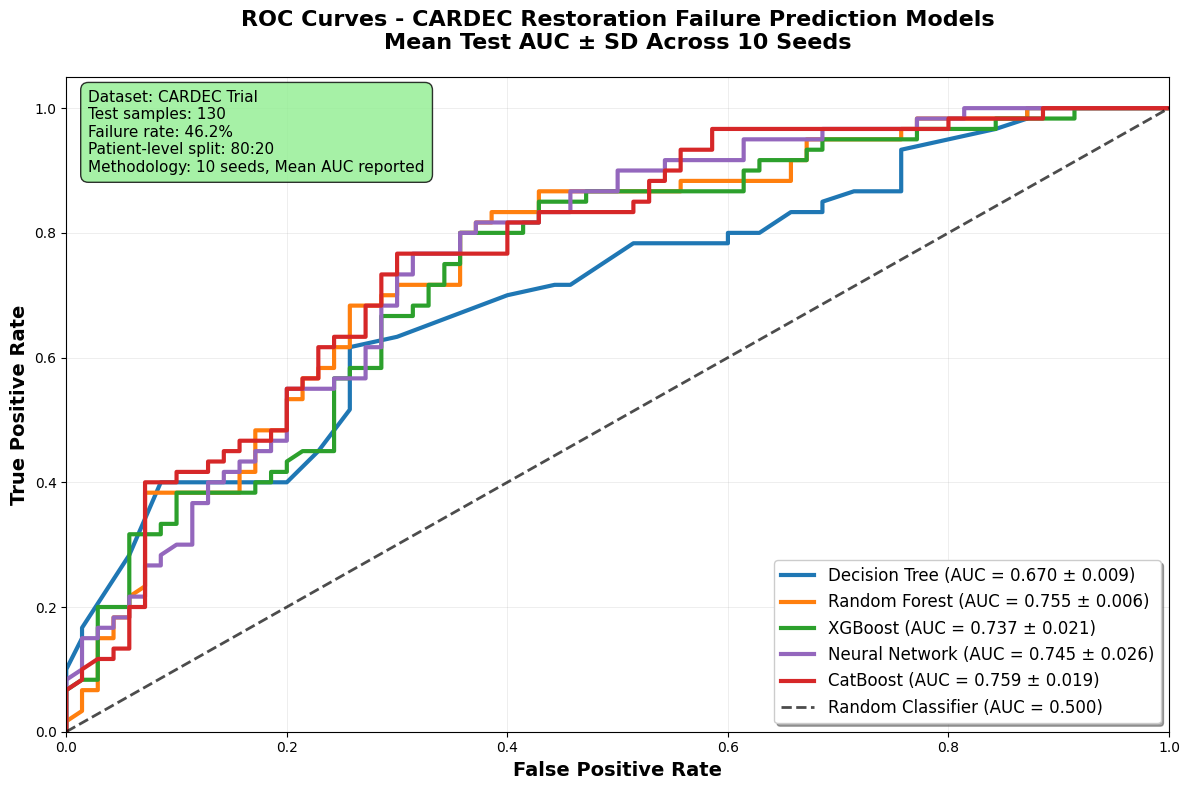

ROC curves saved as 'roc_curves_cardec_mean_test_auc.png'

Note: ROC curves now display Mean Test AUC ± SD across 10 seeds in the legend.
Curves are plotted using averaged predictions for smooth visualization.


In [14]:
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.metrics import roc_curve, roc_auc_score, accuracy_score, precision_score, recall_score, f1_score
import numpy as np

# Create comprehensive comparison table and ROC curves
print("\n" + "="*80)
print("COMPREHENSIVE MODEL COMPARISON - CARDEC DATASET")
print("="*80)

# Collect all models and their performance metrics
# IMPORTANTE: Agora usamos o auc_mean (média dos AUCs dos 10 seeds) para comparação
models_comparison = {
    'Decision Tree': {
        'avg_predictions': dt_avg_predictions,
        'auc_mean': dt_results['auc_mean'],
        'auc_std': dt_results['auc_std'],
        'accuracy_mean': dt_results['accuracy_mean'],
        'precision_mean': dt_results['precision_mean'],
        'recall_mean': dt_results['recall_mean'],
        'f1_mean': dt_results['f1_mean'],
        'threshold_mean': dt_results['threshold_mean']
    },
    'Random Forest': {
        'avg_predictions': rf_avg_predictions,
        'auc_mean': rf_results['auc_mean'],
        'auc_std': rf_results['auc_std'],
        'accuracy_mean': rf_results['accuracy_mean'],
        'precision_mean': rf_results['precision_mean'],
        'recall_mean': rf_results['recall_mean'],
        'f1_mean': rf_results['f1_mean'],
        'threshold_mean': rf_results['threshold_mean']
    },
    'XGBoost': {
        'avg_predictions': xgb_avg_predictions,
        'auc_mean': xgb_results['auc_mean'],
        'auc_std': xgb_results['auc_std'],
        'accuracy_mean': xgb_results['accuracy_mean'],
        'precision_mean': xgb_results['precision_mean'],
        'recall_mean': xgb_results['recall_mean'],
        'f1_mean': xgb_results['f1_mean'],
        'threshold_mean': xgb_results['threshold_mean']
    },
    'Neural Network': {
        'avg_predictions': nn_avg_predictions,
        'auc_mean': nn_results['auc_mean'],
        'auc_std': nn_results['auc_std'],
        'accuracy_mean': nn_results['accuracy_mean'],
        'precision_mean': nn_results['precision_mean'],
        'recall_mean': nn_results['recall_mean'],
        'f1_mean': nn_results['f1_mean'],
        'threshold_mean': nn_results['threshold_mean']
    },
    'CatBoost': {
        'avg_predictions': cb_avg_predictions,
        'auc_mean': cb_results['auc_mean'],
        'auc_std': cb_results['auc_std'],
        'accuracy_mean': cb_results['accuracy_mean'],
        'precision_mean': cb_results['precision_mean'],
        'recall_mean': cb_results['recall_mean'],
        'f1_mean': cb_results['f1_mean'],
        'threshold_mean': cb_results['threshold_mean']
    }
}

# Create comparison table using Mean Test AUC
comparison_data = []
for model_name, metrics in models_comparison.items():
    # Calculate metrics using averaged predictions for display consistency
    avg_pred = metrics['avg_predictions']
    optimal_threshold = metrics['threshold_mean']
    y_pred_optimal = (avg_pred >= optimal_threshold).astype(int)

    comparison_data.append({
        'Model': model_name,
        'Mean AUC': f"{metrics['auc_mean']:.4f}",  # Mean Test AUC
        'Accuracy': f"{accuracy_score(y_test, y_pred_optimal):.4f}",
        'Precision': f"{precision_score(y_test, y_pred_optimal, zero_division=0):.4f}",
        'Recall': f"{recall_score(y_test, y_pred_optimal, zero_division=0):.4f}",
        'F1-Score': f"{f1_score(y_test, y_pred_optimal, zero_division=0):.4f}",
        'Threshold': f"{optimal_threshold:.3f}"
    })

comparison_df = pd.DataFrame(comparison_data)
print("\nFinal Model Performance (Mean Test AUC ± SD):")
print(comparison_df.to_string(index=False))

# Create ROC curves plot
plt.figure(figsize=(12, 8))

# Plot ROC curve for each model
colors = ['#1f77b4', '#ff7f0e', '#2ca02c', '#9467bd', '#d62728']
model_names = ['Decision Tree', 'Random Forest', 'XGBoost', 'Neural Network', 'CatBoost']

for i, model_name in enumerate(model_names):
    model_data = models_comparison[model_name]

    # Calculate FPR and TPR using averaged predictions (for smooth curve)
    fpr, tpr, _ = roc_curve(y_test, model_data['avg_predictions'])

    # MUDANÇA PRINCIPAL: Usar auc_mean ± auc_std no label
    auc_mean = model_data['auc_mean']
    auc_std = model_data['auc_std']

    plt.plot(fpr, tpr, linewidth=3, color=colors[i],
             label=f'{model_name} (AUC = {auc_mean:.3f} ± {auc_std:.3f})')

# Plot diagonal line (random classifier)
plt.plot([0, 1], [0, 1], 'k--', linewidth=2, alpha=0.7, label='Random Classifier (AUC = 0.500)')

# Formatting
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate', fontsize=14, fontweight='bold')
plt.ylabel('True Positive Rate', fontsize=14, fontweight='bold')
plt.title('ROC Curves - CARDEC Restoration Failure Prediction Models\nMean Test AUC ± SD Across 10 Seeds',
          fontsize=16, fontweight='bold', pad=20)
plt.legend(loc="lower right", fontsize=12, frameon=True, fancybox=True, shadow=True)
plt.grid(True, alpha=0.3, linestyle='-', linewidth=0.5)

# Add text box with dataset information
textstr = (
    f'Dataset: CARDEC Trial\n'
    f'Test samples: {len(y_test)}\n'
    f'Failure rate: {y_test.mean():.1%}\n'
    f'Patient-level split: 80:20\n'
    f'Methodology: 10 seeds, Mean AUC reported'
)
props = dict(boxstyle='round,pad=0.5', facecolor='lightgreen', alpha=0.8)
plt.text(0.02, 0.98, textstr, transform=plt.gca().transAxes, fontsize=11,
         verticalalignment='top', bbox=props)

plt.tight_layout()
plt.savefig('roc_curves_cardec_mean_test_auc.png', dpi=300, bbox_inches='tight')
plt.show()

print("ROC curves saved as 'roc_curves_cardec_mean_test_auc.png'")
print("\nNote: ROC curves now display Mean Test AUC ± SD across 10 seeds in the legend.")
print("Curves are plotted using averaged predictions for smooth visualization.")

## SHAP Analysis
### Feature importance analysis for the best model

In [20]:
# SHAP Analysis for the best performing model
import shap
from imblearn.over_sampling import SMOTE

# Find best model by mean AUC from the models_comparison dictionary
best_model_name = max(models_comparison.keys(), key=lambda x: models_comparison[x]['auc_mean'])
best_model_data = models_comparison[best_model_name]
best_model_obj = None

# Get the actual trained model object
if best_model_name == 'Decision Tree':
    # Get the best model object from the detailed results for this model
    best_model_obj = dt_results['best_model']
elif best_model_name == 'Random Forest':
    best_model_obj = rf_results['best_model']
elif best_model_name == 'XGBoost':
    best_model_obj = xgb_results['best_model']
elif best_model_name == 'CatBoost':
    best_model_obj = cb_results['best_model']
elif best_model_name == 'Neural Network':
    best_model_obj = nn_results['best_model']

print(f"Creating SHAP analysis for best model: {best_model_name}")
print(f"Best model Mean Test AUC: {best_model_data['auc_mean']:.3f}")


# For Neural Network, we need to use a different approach
if best_model_name == 'Neural Network':
    print("Note: SHAP analysis for Neural Network requires special handling.")
    print("Using the best tree-based model for SHAP analysis instead based on Mean Test AUC.")

    # Use best tree-based model for SHAP based on Mean Test AUC
    tree_models = {}
    if 'dt_results' in locals():
         tree_models['Decision Tree'] = {'auc_mean': dt_results['auc_mean'], 'best_model': dt_results['best_model']}
    if 'rf_results' in locals():
         tree_models['Random Forest'] = {'auc_mean': rf_results['auc_mean'], 'best_model': rf_results['best_model']}
    if 'xgb_results' in locals():
         tree_models['XGBoost'] = {'auc_mean': xgb_results['auc_mean'], 'best_model': xgb_results['best_model']}
    if 'cb_results' in locals():
         tree_models['CatBoost'] = {'auc_mean': cb_results['auc_mean'], 'best_model': cb_results['best_model']}


    best_tree_model_name = max(tree_models.keys(), key=lambda x: tree_models[x]['auc_mean'])
    best_model_obj = tree_models[best_tree_model_name]['best_model']
    best_model_name = best_tree_model_name
    print(f"Using {best_model_name} for SHAP analysis (Mean Test AUC: {tree_models[best_model_name]['auc_mean']:.3f})")


# Get the trained classifier from the pipeline (for pipeline models)
if hasattr(best_model_obj, 'named_steps'):
    classifier = best_model_obj.named_steps['classifier']
else:
    classifier = best_model_obj

# Create SHAP explainer
print("Creating SHAP explainer...")
explainer = shap.TreeExplainer(classifier)

# Calculate SHAP values for test set (use subset for speed)
print("Calculating SHAP values...")
# Ensure X_test is a pandas DataFrame for SHAP
X_test_df = pd.DataFrame(X_test, columns=X_train.columns)

shap_values = explainer.shap_values(X_test_df[:100])  # Use first 100 samples

if isinstance(shap_values, list):
    shap_values = shap_values[1]  # For binary classification, take positive class

print(f"SHAP values shape: {shap_values.shape}")

Creating SHAP analysis for best model: CatBoost
Best model Mean Test AUC: 0.759
Creating SHAP explainer...
Calculating SHAP values...
SHAP values shape: (100, 14)


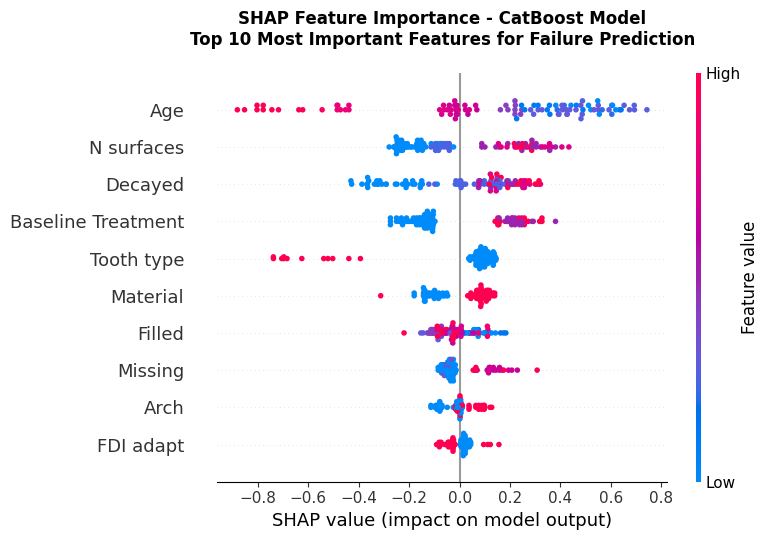

SHAP summary plot saved as 'shap_summary_plot_failure.png'


In [21]:
# Create SHAP summary plot (beeswarm plot)
plt.figure(figsize=(8, 5.5))
shap.summary_plot(shap_values, X_test[:100], max_display=10, show=False)
plt.title(f'SHAP Feature Importance - {best_model_name} Model\nTop 10 Most Important Features for Failure Prediction',
          fontsize=12, fontweight='bold', pad=20)
plt.tight_layout()
plt.savefig('shap_summary_plot_failure.png', dpi=300, bbox_inches='tight')
plt.show()

print("SHAP summary plot saved as 'shap_summary_plot_failure.png'")

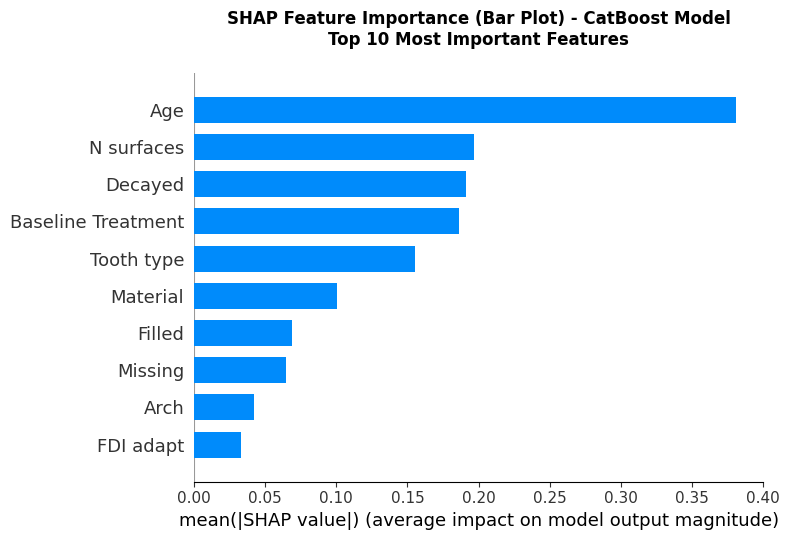

SHAP bar plot saved as 'shap_bar_plot_failure.png'


In [22]:
# Create SHAP bar plot (feature importance)
plt.figure(figsize=(8, 5.5))
shap.summary_plot(shap_values, X_test[:100], plot_type="bar", max_display=10, show=False)
plt.title(f'SHAP Feature Importance (Bar Plot) - {best_model_name} Model\nTop 10 Most Important Features',
          fontsize=12, fontweight='bold', pad=20)
plt.tight_layout()
plt.savefig('shap_bar_plot_failure.png', dpi=300, bbox_inches='tight')
plt.show()

print("SHAP bar plot saved as 'shap_bar_plot_failure.png'")

In [23]:
# Calculate and save feature importance
feature_importance = np.abs(shap_values).mean(0)

# Create DataFrame with feature names and importance
feature_names = X_test.columns if hasattr(X_test, 'columns') else [f'Feature_{i}' for i in range(X_test.shape[1])]
importance_df = pd.DataFrame({
    'Feature': feature_names,
    'Importance': feature_importance
})

# Sort by importance
importance_df = importance_df.sort_values('Importance', ascending=False)

print("\nTop 10 Most Important Features (SHAP):")
print(importance_df.head(10).to_string(index=False))

# Save to CSV
importance_df.to_csv('feature_importance_shap_failure.csv', index=False)
print("\nFeature importance saved as 'feature_importance_shap_failure.csv'")


Top 10 Most Important Features (SHAP):
           Feature  Importance
               Age    0.381079
        N surfaces    0.196680
           Decayed    0.191021
Baseline Treatment    0.186226
        Tooth type    0.155592
          Material    0.100384
            Filled    0.068889
           Missing    0.064613
              Arch    0.042152
         FDI adapt    0.032912

Feature importance saved as 'feature_importance_shap_failure.csv'


---

# Calibration Metrics Analysis - CARDEC Trial - Any Failure (Primary Teeth)

This section calculates calibration metrics for all models:
- Calibration plots (reliability diagrams)
- Calibration slope
- Calibration-in-the-large (CITL)
- Observed/Expected (O/E) ratio
- Brier Score

In [ ]:
# ============================================================================
# CALIBRATION METRICS ANALYSIS
# ============================================================================
# This section calculates calibration metrics as requested by the reviewer:
# - Calibration plots (reliability diagrams)
# - Calibration slope
# - Calibration-in-the-large (CITL)
# - Observed/Expected (O/E) ratio
# ============================================================================

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.calibration import calibration_curve
from sklearn.linear_model import LogisticRegression
import warnings
warnings.filterwarnings('ignore')

def calculate_calibration_metrics(y_true, y_pred_proba, model_name, n_bins=10):
    
    # Convert to numpy arrays
    y_true = np.array(y_true).ravel()
    y_pred_proba = np.array(y_pred_proba).ravel()

    # 1. Calculate calibration curve (for plotting)
    prob_true, prob_pred = calibration_curve(y_true, y_pred_proba, n_bins=n_bins, strategy='uniform')

    # 2. Calculate O/E ratio (Observed/Expected)
    expected = np.sum(y_pred_proba)
    observed = np.sum(y_true)
    oe_ratio = observed / expected if expected > 0 else np.nan

    # 3. Calculate Calibration Slope and Calibration-in-the-large (CITL)
    y_pred_clipped = np.clip(y_pred_proba, 1e-10, 1 - 1e-10)
    log_odds = np.log(y_pred_clipped / (1 - y_pred_clipped))

    log_odds_reshaped = log_odds.reshape(-1, 1)
    lr = LogisticRegression(solver='lbfgs', max_iter=1000)
    lr.fit(log_odds_reshaped, y_true)

    calibration_slope = lr.coef_[0][0]
    citl = lr.intercept_[0]

    # 4. Calculate Brier Score
    brier_score = np.mean((y_pred_proba - y_true) ** 2)

    return {
        'model_name': model_name,
        'prob_true': prob_true,
        'prob_pred': prob_pred,
        'calibration_slope': calibration_slope,
        'citl': citl,
        'oe_ratio': oe_ratio,
        'brier_score': brier_score,
        'observed': observed,
        'expected': expected
    }


def plot_calibration_curves(calibration_results, dataset_name, save_path):
    """
    Plot calibration curves for all models.
    """
    fig, axes = plt.subplots(2, 3, figsize=(15, 10))
    axes = axes.flatten()

    colors = ['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728', '#9467bd']

    for idx, result in enumerate(calibration_results):
        ax = axes[idx]
        ax.plot([0, 1], [0, 1], 'k--', linewidth=2, label='Perfect calibration')
        ax.plot(result['prob_pred'], result['prob_true'],
                's-', color=colors[idx], linewidth=2, markersize=8,
                label=f"{result['model_name']}")

        metrics_text = (
            f"Slope: {result['calibration_slope']:.3f}\n"
            f"CITL: {result['citl']:.3f}\n"
            f"O/E: {result['oe_ratio']:.3f}\n"
            f"Brier: {result['brier_score']:.3f}"
        )
        ax.text(0.05, 0.95, metrics_text, transform=ax.transAxes,
                fontsize=10, verticalalignment='top',
                bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.5))

        ax.set_xlabel('Mean Predicted Probability', fontsize=11)
        ax.set_ylabel('Fraction of Positives', fontsize=11)
        ax.set_title(f'{result["model_name"]}', fontsize=12, fontweight='bold')
        ax.legend(loc='lower right', fontsize=9)
        ax.set_xlim([0, 1])
        ax.set_ylim([0, 1])
        ax.grid(True, alpha=0.3)

    ax = axes[5]
    ax.plot([0, 1], [0, 1], 'k--', linewidth=2, label='Perfect calibration')
    for idx, result in enumerate(calibration_results):
        ax.plot(result['prob_pred'], result['prob_true'],
                's-', color=colors[idx], linewidth=2, markersize=6,
                label=f"{result['model_name']}")
    ax.set_xlabel('Mean Predicted Probability', fontsize=11)
    ax.set_ylabel('Fraction of Positives', fontsize=11)
    ax.set_title('All Models Comparison', fontsize=12, fontweight='bold')
    ax.legend(loc='lower right', fontsize=8)
    ax.set_xlim([0, 1])
    ax.set_ylim([0, 1])
    ax.grid(True, alpha=0.3)

    plt.suptitle(f'Calibration Plots - {dataset_name}\n(Reliability Diagrams)',
                 fontsize=14, fontweight='bold', y=1.02)
    plt.tight_layout()
    plt.savefig(save_path, dpi=300, bbox_inches='tight')
    plt.show()

    print(f"\nCalibration plots saved as '{save_path}'")


def print_calibration_summary(calibration_results, dataset_name, csv_filename):
    """
    Print a summary table of calibration metrics.
    """
    print("\n" + "="*80)
    print(f"CALIBRATION METRICS SUMMARY - {dataset_name}")
    print("="*80)
    print("-"*80)

    summary_data = []
    for result in calibration_results:
        summary_data.append({
            'Model': result['model_name'],
            'Calibration Slope': f"{result['calibration_slope']:.3f}",
            'CITL': f"{result['citl']:.3f}",
            'O/E Ratio': f"{result['oe_ratio']:.3f}",
            'Brier Score': f"{result['brier_score']:.4f}",
            'Observed': int(result['observed']),
            'Expected': f"{result['expected']:.1f}"
        })

    summary_df = pd.DataFrame(summary_data)
    print("\n" + summary_df.to_string(index=False))
    print("-"*80)

    summary_df.to_csv(csv_filename, index=False)
    print(f"\nCalibration metrics saved as '{csv_filename}'")

    return summary_df


# ============================================================================
# MAIN CALIBRATION ANALYSIS
# ============================================================================
DATASET_NAME = "CARDEC Trial - Any Failure (Primary Teeth)"

print("\n" + "="*80)
print("CALCULATING CALIBRATION METRICS FOR ALL MODELS")
print("="*80)

calibration_results = []

# Decision Tree
dt_calibration = calculate_calibration_metrics(y_test, dt_avg_predictions, 'Decision Tree')
calibration_results.append(dt_calibration)
print("✓ Decision Tree calibration metrics calculated")

# Random Forest
rf_calibration = calculate_calibration_metrics(y_test, rf_avg_predictions, 'Random Forest')
calibration_results.append(rf_calibration)
print("✓ Random Forest calibration metrics calculated")

# XGBoost
xgb_calibration = calculate_calibration_metrics(y_test, xgb_avg_predictions, 'XGBoost')
calibration_results.append(xgb_calibration)
print("✓ XGBoost calibration metrics calculated")

# CatBoost
cb_calibration = calculate_calibration_metrics(y_test, cb_avg_predictions, 'CatBoost')
calibration_results.append(cb_calibration)
print("✓ CatBoost calibration metrics calculated")

# Neural Network
nn_calibration = calculate_calibration_metrics(y_test, nn_avg_predictions, 'Neural Network')
calibration_results.append(nn_calibration)
print("✓ Neural Network calibration metrics calculated")

# Print summary table
calibration_summary_df = print_calibration_summary(calibration_results, DATASET_NAME, 'calibration_metrics_cardec_global.csv')

# Plot calibration curves
plot_calibration_curves(calibration_results, DATASET_NAME, 'calibration_plots_cardec_global.png')

print("\n" + "="*80)
print("CALIBRATION ANALYSIS COMPLETE")
print("="*80)
